In [1]:
!pip install catboost

     |████████████████████████████████| 64.8MB 45kB/s 


### Mounting the Drive for Data Downloading

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True) 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
!cp "/content/gdrive/My Drive/Colab Notebooks/Projects/kaggle.json" .

In [5]:
!mkdir -p ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

### Import

In [8]:
# Import Dependencies
%matplotlib inline

# Define System
import os
import sys

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Deep Learning
import tensorflow as tf
import tensorflow.keras as keras

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')
print('Libraries Imported!')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Libraries Imported!


In [9]:
print("python", sys.version)
for module in catboost, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
catboost 0.23.2
numpy 1.18.5
pandas 1.0.5
sklearn 0.22.2.post1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [10]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

### Loading in the data

In [11]:
# !kaggle competitions download -c titanic

In [12]:
# Import train & test data 
# train = pd.read_csv('/content/test.csv')
# test = pd.read_csv('/content/train.csv')

In [13]:
# View the training data
#train.head(15)

In [14]:
# Import train & test data 
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projects/titanic/train.csv')
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Projects/titanic/test.csv')

In [15]:
train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


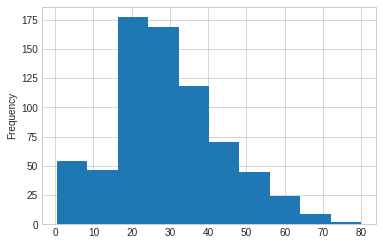

In [16]:
train.Age.plot.hist()

In [17]:
# View the test data (same columns as the training data)
test.head() # head = view first 5 lines

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Data Descriptions

**Survival:** 0 = No, 1 = Yes

**pclass (Ticket class):** 1 = 1st, 2 = 2nd, 3 = 3rd

**sex:** Sex

**Age:** Age in years

**sibsp:** number of siblings/spouses aboard the Titanic

**parch:** number of parents/children aboard the Titanic

**ticket:** Ticket number

**fare:** Passenger fare

**cabin:** Cabin number

**embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton


In [18]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


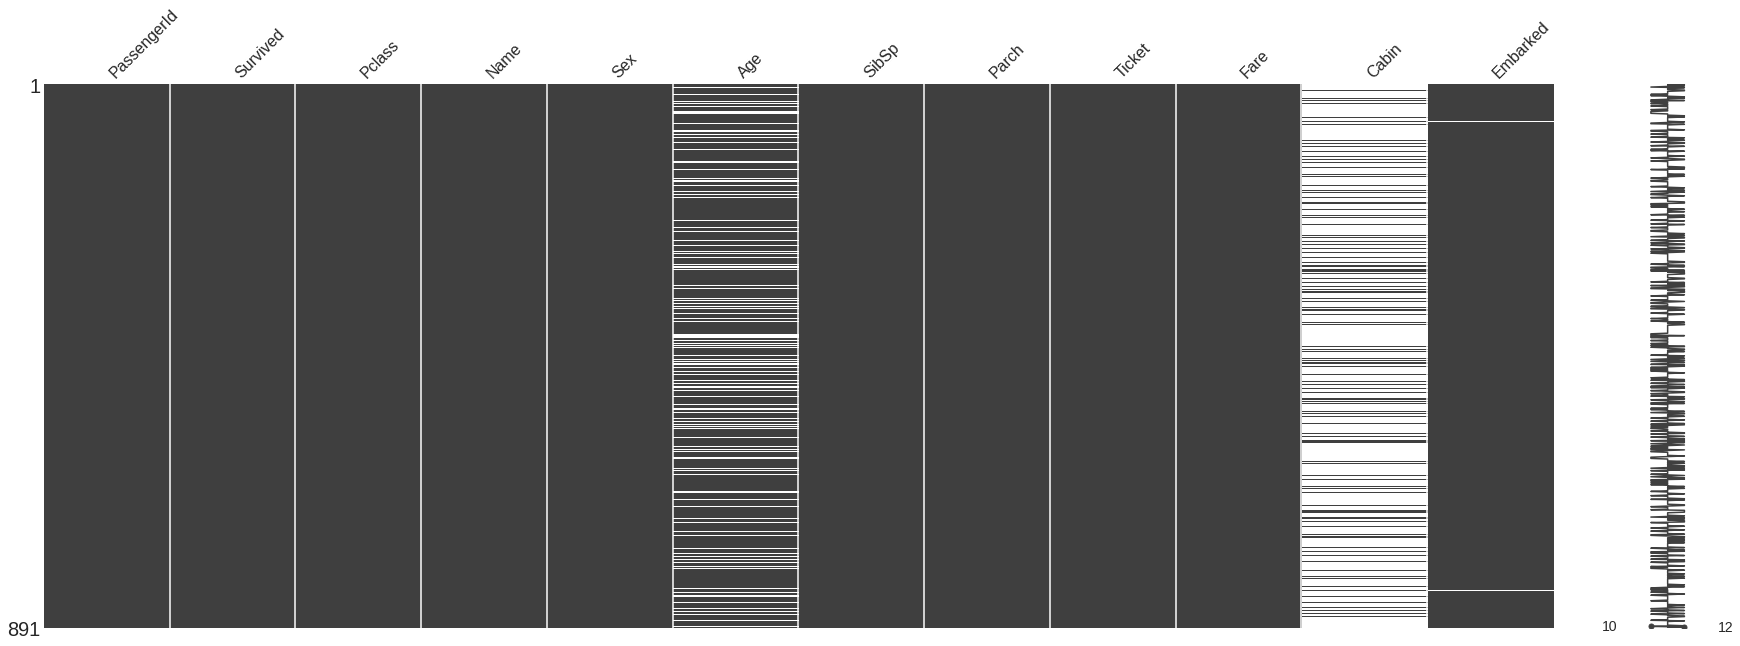

In [19]:
# Plot graphic of missing values
missingno.matrix(train, figsize = (30,10));

In [20]:
# Alternatively, you can see the number of missing values like this
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [21]:
df_bin = pd.DataFrame() # for discretised continuous variables
df_con = pd.DataFrame() # for continuous variables

In [22]:
# Different data types in the dataset
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Let's explore each of these features individually


In [23]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


0    549
1    342
Name: Survived, dtype: int64


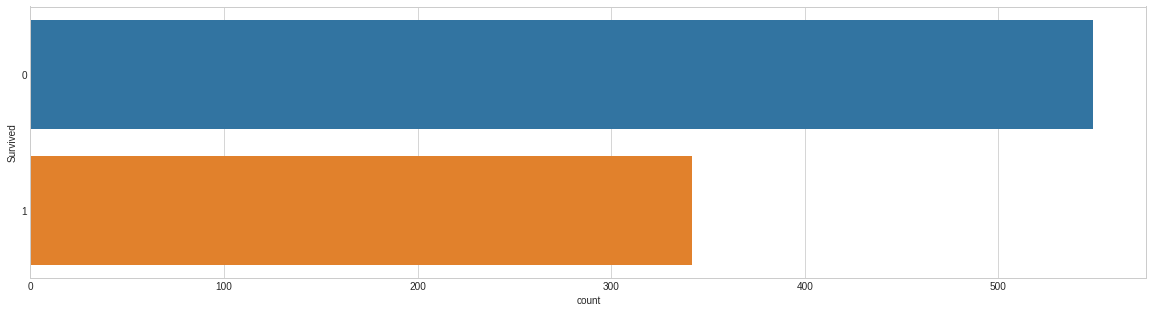

In [24]:
# How many people survived?
plt.figure(figsize=(20, 5))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [25]:
# Let's add this to our subset dataframes
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [26]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [27]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


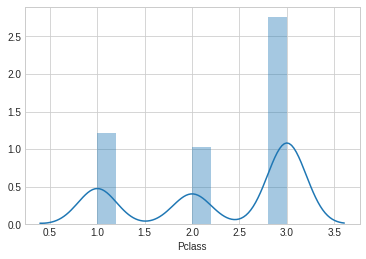

In [28]:
sns.distplot(train.Pclass)

In [29]:
# How many missing variables does Pclass have?
train.Pclass.isnull().sum()

0

In [30]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [31]:
# How many different names are there?
train.Name.value_counts()

Olsvigen, Mr. Thor Anderson    1
Burke, Mr. Jeremiah            1
Mamee, Mr. Hanna               1
Bystrom, Mrs. (Karolina)       1
Sundman, Mr. Johan Julian      1
                              ..
Kantor, Mr. Sinai              1
Farthing, Mr. John             1
Allen, Mr. William Henry       1
Futrelle, Mr. Jacques Heath    1
Greenberg, Mr. Samuel          1
Name: Name, Length: 891, dtype: int64

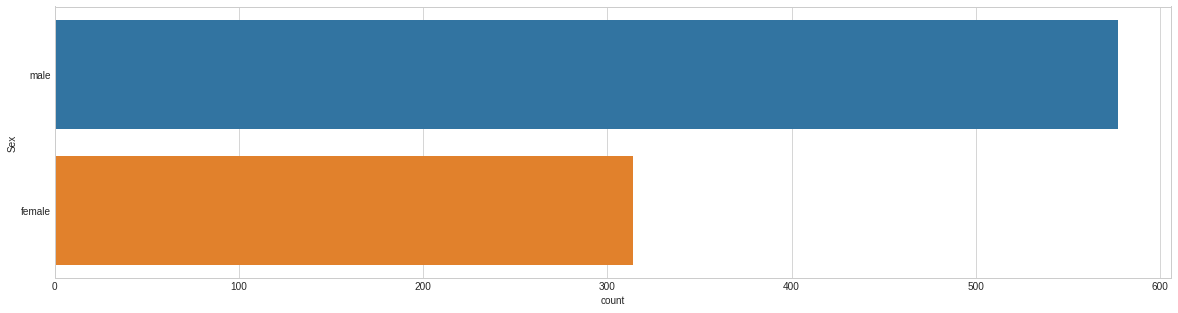

In [32]:
# Let's view the distribution of Sex
plt.figure(figsize=(20, 5))
sns.countplot(y="Sex", data=train);

In [33]:
# Are there any missing values in the Sex column?
train.Sex.isnull().sum()

0

In [34]:
train.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [35]:
# add Sex to the subset dataframes
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']

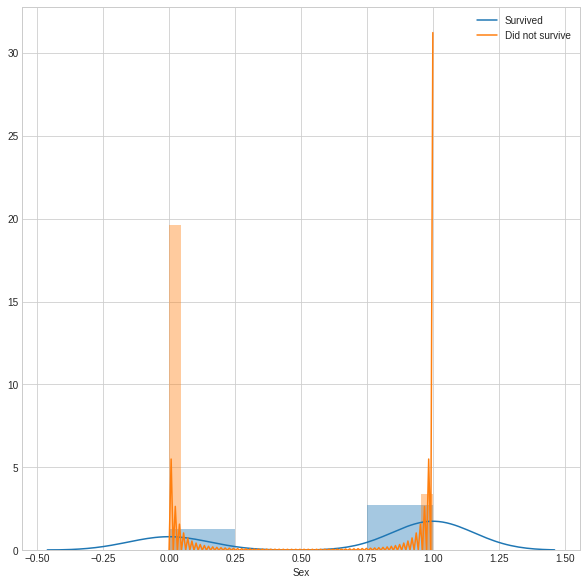

In [36]:
# How does the Sex variable look compared to Survival?
# We can see this because they're both binarys.
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

In [37]:
# How many missing values does age have?
train.Age.isnull().sum()

177

In [38]:
# Once the Age values have been fixed up, we can add them to our sub dataframes.
# df_bin['Age'] = pd.cut(train['Age'], 10) # bucketed/binned into different categories
# df_con['Age'] = train['Age'] # non-bucketed

#### Function to create count and distribution visualisations

In [39]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

In [40]:
# How many missing values does SibSp have?
train.SibSp.isnull().sum()

0

In [41]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [42]:
# Add SibSp to subset dataframes
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

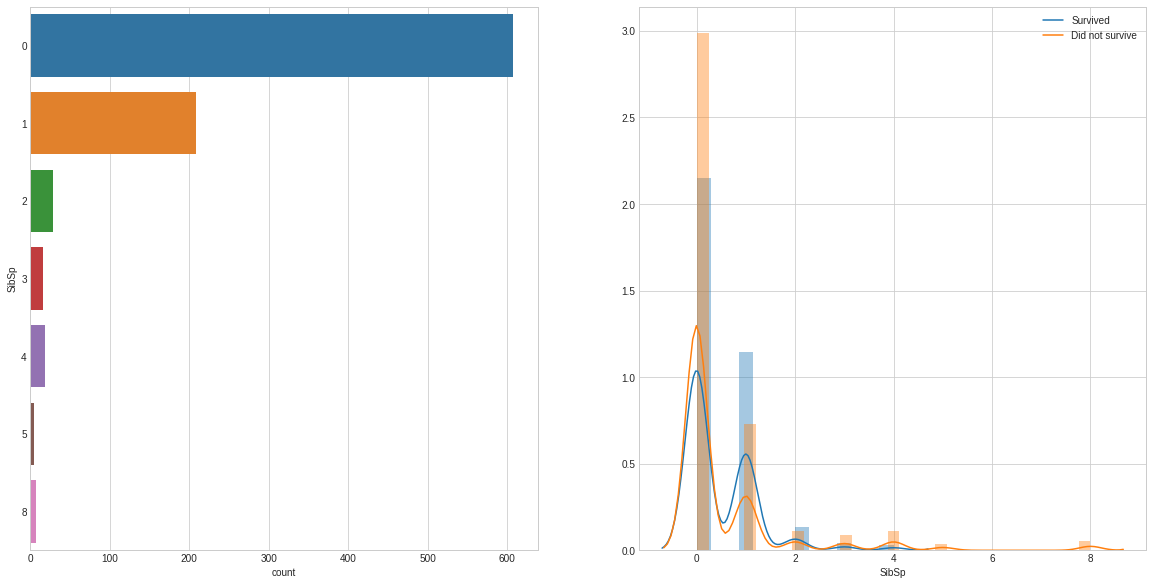

In [43]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

In [44]:
# How many missing values does Parch have?
train.Parch.isnull().sum()

0

In [45]:
# What values are there?
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [46]:
train.Parch.groupby(train['Survived']).value_counts()

Survived  Parch
0         0        445
          1         53
          2         40
          4          4
          5          4
          3          2
          6          1
1         0        233
          1         65
          2         40
          3          3
          5          1
Name: Parch, dtype: int64

In [47]:
# Add Parch to subset dataframes
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

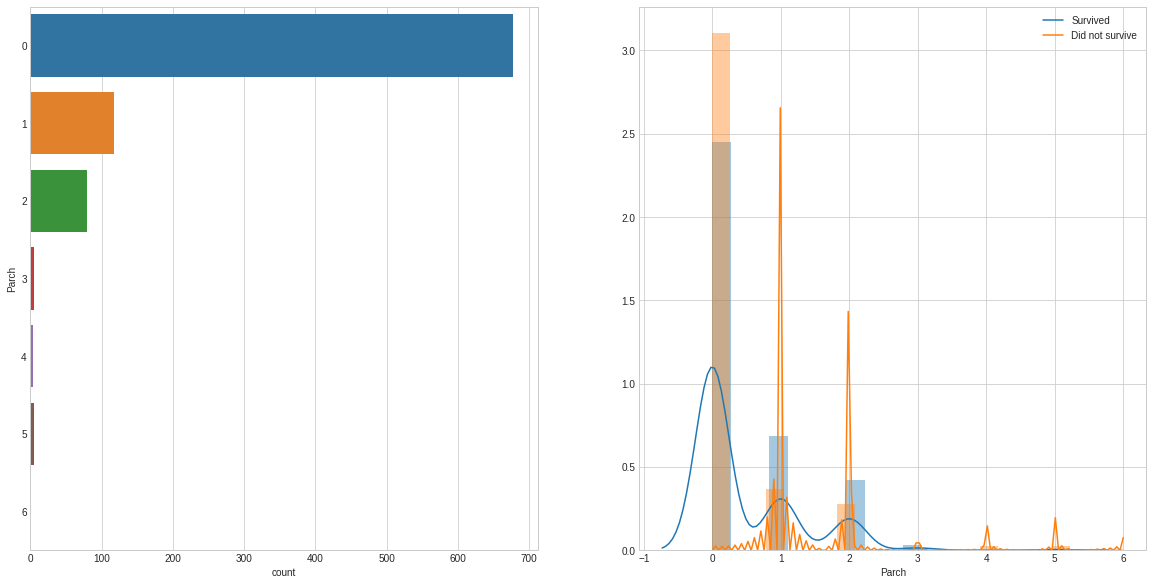

In [48]:
# Visualise the counts of Parch and the distribution of the values
# against Survived
plot_count_dist(train, 
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

In [49]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,0,1,0
1,1,1,1,1,0
2,1,3,1,0,0
3,1,1,1,1,0
4,0,3,0,0,0


In [51]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,male,1,0
1,1,1,female,1,0
2,1,3,female,0,0
3,1,1,female,1,0
4,0,3,male,0,0


In [52]:
# How many missing values does Ticket have?
train.Ticket.isnull().sum()

0

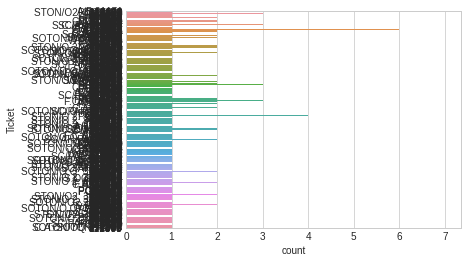

In [53]:
# How many kinds of ticket are there?
sns.countplot(y="Ticket", data=train);

In [54]:
len(train.Ticket)

891

In [55]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

CA. 2343    7
1601        7
347082      7
347088      6
3101295     6
           ..
349217      1
211536      1
2623        1
C 4001      1
394140      1
Name: Ticket, Length: 681, dtype: int64

In [56]:
# How many unique kinds of Ticket are there?
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


In [57]:
# How many missing values does Fare have?
train.Fare.isnull().sum()

0

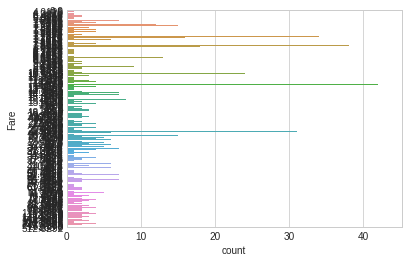

In [58]:
# How many different values of Fare are there?
sns.countplot(y="Fare", data=train);

In [59]:
# What kind of variable is Fare?
train.Fare.dtype

dtype('float64')

In [60]:
# How many unique kinds of Fare are there?
print("There are {} unique Fare values.".format(len(train.Fare.unique())))

There are 248 unique Fare values.


In [61]:
# Add Fare to sub dataframes
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised

In [62]:
# What do our Fare bins look like?
df_bin.Fare.value_counts()

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

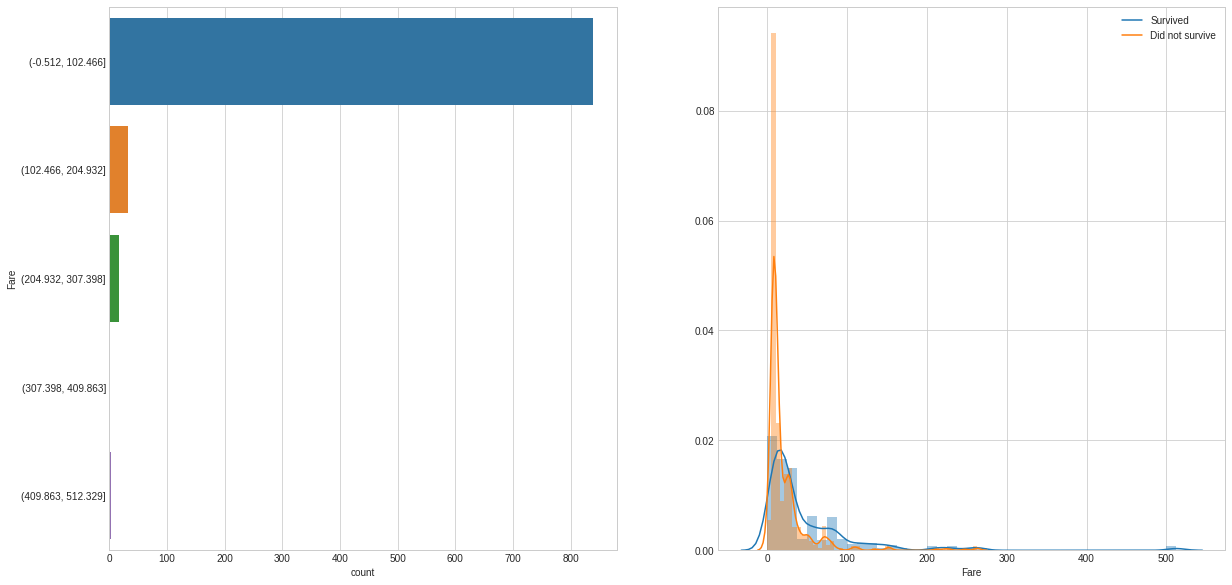

In [63]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived.
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

In [64]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [65]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,0,1,0,"(-0.512, 102.466]"
1,1,1,1,1,0,"(-0.512, 102.466]"
2,1,3,1,0,0,"(-0.512, 102.466]"
3,1,1,1,1,0,"(-0.512, 102.466]"
4,0,3,0,0,0,"(-0.512, 102.466]"


In [66]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare
0,0,3,male,1,0,7.2500
1,1,1,female,1,0,71.2833
2,1,3,female,0,0,7.9250
3,1,1,female,1,0,53.1000
4,0,3,male,0,0,8.0500


In [67]:
# How many missing values does Cabin have?
train.Cabin.isnull().sum()

687

In [68]:
# What do the Cabin values look like?
train.Cabin.value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
F33            3
D              3
              ..
E34            1
A14            1
B101           1
A6             1
A36            1
Name: Cabin, Length: 147, dtype: int64

In [69]:
# How many missing values does Embarked have?
train.Embarked.isnull().sum()

2

In [70]:
# Key: C = Cherbourg, Q = Queenstown, S = Southampton
# What kind of values are in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

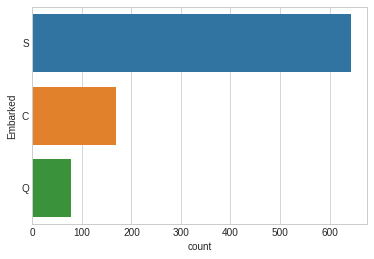

In [71]:
# What do the counts look like?
sns.countplot(y='Embarked', data=train);

In [72]:
# Add Embarked to sub dataframes
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [73]:
# Remove Embarked rows which are missing values
print(len(df_con))
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])
print(len(df_con))

891
889


### Feature Encoding

In [74]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S


In [75]:
# One-hot encode binned variables
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [76]:
df_con.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,male,1,0,7.2500,S
1,1,1,female,1,0,71.2833,C
2,1,3,female,0,0,7.9250,S
3,1,1,female,1,0,53.1000,S
4,0,3,male,0,0,8.0500,S


In [77]:
# One hot encode the categorical columns
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [78]:
# Combine the one hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

# Drop the original categorical columns (because now they've been one hot encoded)
df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [79]:
# Let's look at df_con_enc
df_con_enc.head(20)

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1
5,0,0,0,8.4583,0,1,0,0,1,0,0,1
6,0,0,0,51.8625,0,0,1,0,1,1,0,0
7,0,3,1,21.0750,0,0,1,0,1,0,0,1
8,1,0,2,11.1333,0,0,1,1,0,0,0,1
9,1,1,0,30.0708,1,0,0,1,0,0,1,0


### Start Building Machine Learning Models

#### Let's seperate the data


In [80]:
# Seclect the dataframe we want to use first for predictions - Cont Encoded!
selected_df = df_con_enc

In [81]:
selected_df.head()

,Survived,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,0,8.0500,0,0,1,0,1,0,0,1


In [82]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [83]:
# Shape of the data (without labels)
X_train.shape

(889, 11)

In [84]:
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [85]:
# Shape of the labels
y_train.shape

(889,)

#### Define a function to fit machine learning algorithms

In [86]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

#### 1. Logistic Regression

In [87]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 79.98
Accuracy CV 10-Fold: 79.42
Running Time: 0:00:01.894730


#### K-Nearest Neighbours

In [88]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.46
Accuracy CV 10-Fold: 76.72
Running Time: 0:00:00.173471


#### Gaussian Naive Bayes¶

In [108]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.52
Accuracy CV 10-Fold: 77.95
Running Time: 0:00:01.249153


#### Linear Support Vector Machines (SVC)


In [89]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.07
Accuracy CV 10-Fold: 77.05
Running Time: 0:00:00.446333


#### Stochastic Gradient Descent

In [90]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 77.62
Accuracy CV 10-Fold: 69.85
Running Time: 0:00:00.132393


#### Decision Tree Classifier

In [91]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.46
Accuracy CV 10-Fold: 80.43
Running Time: 0:00:00.095364


#### Gradient Boost Trees

In [92]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 86.61
Accuracy CV 10-Fold: 80.65
Running Time: 0:00:01.052597


#### CatBoost Algorithm
CatBoost is a state-of-the-art open-source gradient boosting on decision trees library.

In [93]:
# View the data for the CatBoost model
X_train.head()

,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,0,71.2833,1,0,0,1,0,1,0,0
2,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,0,8.0500,0,0,1,0,1,0,0,1


In [94]:
# View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [97]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10])

In [98]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [103]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [104]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6862830	total: 56.5ms	remaining: 56.5s
1:	learn: 0.6809444	total: 59.8ms	remaining: 29.8s
2:	learn: 0.6751692	total: 64.6ms	remaining: 21.5s
3:	learn: 0.6689060	total: 70.1ms	remaining: 17.5s
4:	learn: 0.6632144	total: 74.3ms	remaining: 14.8s
5:	learn: 0.6576488	total: 77.8ms	remaining: 12.9s
6:	learn: 0.6544441	total: 82.8ms	remaining: 11.7s
7:	learn: 0.6490635	total: 86.7ms	remaining: 10.8s
8:	learn: 0.6443241	total: 94.8ms	remaining: 10.4s
9:	learn: 0.6395935	total: 98.2ms	remaining: 9.72s
10:	learn: 0.6345186	total: 101ms	remaining: 9.06s
11:	learn: 0.6305316	total: 104ms	remaining: 8.53s
12:	learn: 0.6275610	total: 116ms	remaining: 8.84s
13:	learn: 0.6225020	total: 121ms	remaining: 8.49s
14:	learn: 0.6179503	total: 123ms	remaining: 8.09s
15:	learn: 0.6140480	total: 124ms	remaining: 7.66s
16:	learn: 0.6100034	total: 127ms	remaining: 7.35s
17:	learn: 0.6049646	total: 131ms	remaining: 7.16s
18:	learn: 0.6025760	total: 133ms	remaining: 6.84s
1

#### Perform CatBoost cross-validation

In [105]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6746718	test: 0.6751020	best: 0.6751020 (0)	total: 276ms	remaining: 4m 36s
1:	learn: 0.6573540	test: 0.6583602	best: 0.6583602 (1)	total: 532ms	remaining: 4m 25s
2:	learn: 0.6408329	test: 0.6429257	best: 0.6429257 (2)	total: 770ms	remaining: 4m 15s
3:	learn: 0.6253924	test: 0.6283059	best: 0.6283059 (3)	total: 1.01s	remaining: 4m 10s
4:	learn: 0.6114190	test: 0.6150989	best: 0.6150989 (4)	total: 1.25s	remaining: 4m 8s
5:	learn: 0.6004513	test: 0.6048524	best: 0.6048524 (5)	total: 1.48s	remaining: 4m 5s
6:	learn: 0.5900482	test: 0.5949158	best: 0.5949158 (6)	total: 1.71s	remaining: 4m 2s
7:	learn: 0.5800356	test: 0.5853301	best: 0.5853301 (7)	total: 1.93s	remaining: 3m 59s
8:	learn: 0.5702086	test: 0.5757925	best: 0.5757925 (8)	total: 2.17s	remaining: 3m 58s
9:	learn: 0.5612227	test: 0.5675857	best: 0.5675857 (9)	total: 2.4s	remaining: 3m 57s
10:	learn: 0.5522686	test: 0.5589941	best: 0.5589941 (10)	total: 2.63s	remaining: 3m 56s
11:	learn: 0.5447302	test: 0.5517930	best: 0.

In [106]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 83.91
Accuracy cross-validation 10-Fold: 81.32
Running Time: 0:04:50.162911


#### ANN

In [129]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(X_train.shape[1])),                        
  tf.keras.layers.Dense(16, activation=tf.nn.relu),  
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                192       
_________________________________________________________________
dense_12 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 373
Trainable params: 373
Non-trainable params: 0
_________________________________________________________________


In [124]:
X_train.shape

(889, 11)

In [132]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1)

Epoch 1/100
178/178 [==============================] - 1s 3ms/step - loss: 0.4129 - accuracy: 0.8189
Epoch 2/100
178/178 [==============================] - 1s 3ms/step - loss: 0.4110 - accuracy: 0.8166
Epoch 3/100
178/178 [==============================] - 1s 3ms/step - loss: 0.4076 - accuracy: 0.8256
Epoch 4/100
178/178 [==============================] - 1s 3ms/step - loss: 0.4139 - accuracy: 0.8178
Epoch 5/100
178/178 [==============================] - 1s 3ms/step - loss: 0.4185 - accuracy: 0.8166
Epoch 6/100
178/178 [==============================] - 1s 3ms/step - loss: 0.4065 - accuracy: 0.8234
Epoch 7/100
178/178 [==============================] - 1s 3ms/step - loss: 0.4094 - accuracy: 0.8166
Epoch 8/100
178/178 [==============================] - 1s 4ms/step - loss: 0.4097 - accuracy: 0.8121
Epoch 9/100
178/178 [==============================] - 1s 3ms/step - loss: 0.4202 - accuracy: 0.8076
Epoch 10/100
178/178 [==============================] - 1s 3ms/step - loss: 0.4079 - accura

In [ ]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(model, 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

### Model Results

#### Regular accuracy scores

In [109]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,92.46
6,Gradient Boosting Trees,86.61
7,CatBoost,83.91
0,KNN,83.46
1,Logistic Regression,79.98
2,Naive Bayes,78.52
4,Linear SVC,78.07
3,Stochastic Gradient Decent,77.62


#### Cross validation Accuracy Scores

In [110]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,81.32
6,Gradient Boosting Trees,80.65
5,Decision Tree,80.43
1,Logistic Regression,79.42
2,Naive Bayes,77.95
4,Linear SVC,77.05
0,KNN,76.72
3,Stochastic Gradient Decent,69.85


### Feature Importance
Which features of the best model were most important for making predictions?


In [111]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png')

,imp,col
4,0.992061,embarked_Q
3,1.213711,embarked_C
5,1.677219,embarked_S
9,2.178083,pclass_2
8,3.243021,pclass_1
0,10.797435,SibSp
10,11.205450,pclass_3
1,13.988886,Parch
2,15.753218,Fare
6,17.695520,sex_female


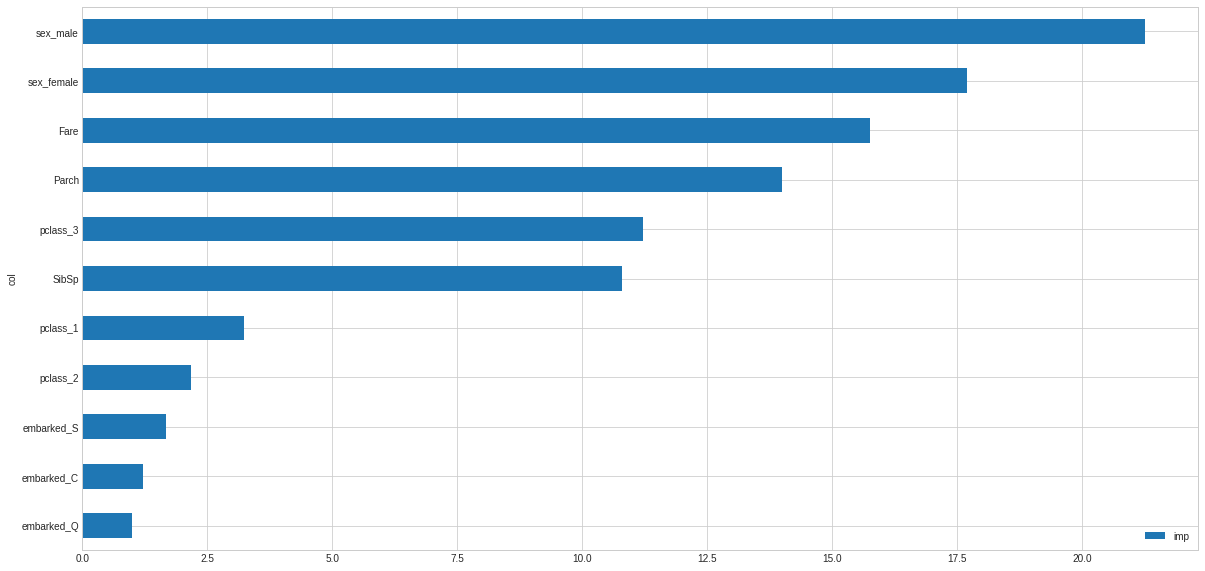

In [112]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

In [113]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8286662683284687
Recall: 0.6833382352941176
F1: 0.7489789466084935
AUC: 0.8842839467480982
